# Model Deployment

There are many approaches to deploying machine learning models. How models get deployed will depend on several things, such as existing infrastructure, how the model predictions will be used, and how quickly they are needed. There is so much variation that it is impossible to be 100% prepared for every scenario, but we can look at the most common deployment patterns and at least get some practice with each one using a fairly simple ML model.

There are two primary patterns for deploying models: offline and online. Offline deployment is commonly referred to as either batch or asynchronous processing, while online deployment is referred to as either real-time or synchronous. Both patterns can be very flexible and complex depending on where the input data is coming from *upstream* and how the predictions will actually be used *downstream*. For the purposes of these demos we will either assume that there are already data pipelines in place that consume raw data and store it (for our offline deployments) and that there is some downstream application that consumes the predictions from the model (also mostly for our offline deployments). For our real-time demo, we will input the data directly to the client (the webapp) and the results will be received directly by us.

The number of technologies and libraries that we can use for our demos is vast, but we will stick to just a handful of simple to use methods for creating quick prototypes. 

## Our Trained Model

For the purposes of this demo I have already trained a very simple model for doing text classification. This model was trained using this [reddit](https://raw.githubusercontent.com/axsauze/reddit-classification-exploration/master/data/reddit_train.csv) dataset which consists of Reddit comments and whether they were removed or not (1 = removed, 0 = not removed). The model is a simple logistic regression model, nothing fancy, and not really important for our purposes. There are two steps to the model: the Reddit comment is processed and vectorized, and then the vector is passed to the logistic regression model.

In order to use the model we need the pipeline that vectorizes the text and contains our model. This pipeline is in Canvas. In practice, we can store these in a model registry using something like MLFlow, or they might already be stored in a datastore if we used Metaflow. Using a registry would be more appropriate for versioning the models but for this demo we'll simply store everything, all data, artifacts, this notebook, and scripts in a new `reddit/` folder. 


## Data

We do have a sample of data which we can use to test out our offline deployment. The sample of data can also be found in Canvas, and we can save it in our `data/` folder (or wherever we want so long as we remember where it is) as 'sample_reddit.csv'. Again, to test the deployment locally, this is fine. But if we were going to truly productionize this, then we should have our batch data sitting in the actual data warehouse or object storage in a *production* environment.

After our model makes predictions we need to write those predictions somewhere. We could set up a sqlite database pretty easily and put them there, but again, let's just dump them into a file for now and not worry about writing all of the code to set up the database, the table, and the queries to insert the new predictions. 



## Offline Deployment

For offline deployment we need to create a scoring script that will do these steps: (1) load data; (2) clean and process data; (3) load model; (4) make predictions; (5) store predictions. We will **load data** from our filesystem, we will **load the model** from our filesystem, and we will **store predictions** to our filesystem. But, if we wanted to, we could make this more robust by storing the input and output data in sqlite tables, and have the model sitting in a datastore or registry created by MLflow or Metaflow.



### Scoring Script

We have a few choices even for how we can write our scoring script. We can simply write a python script that does the above steps in order. We can create flows using Metaflow (or Prefect or something else) which will save all of the flow metadata when the flow is run. How this is done will depend on the team we're working on, but for this demo, let's go ahead and continue to use Metaflow to create a flow that we can run at scoring time and schedule to run using a scheduler such as Airflow or Argo Workflows. We won't do the scheduling part for this demo.

For this demo we will need to install the joblib library for loading our model pipeline.

```
pip install joblib
```

Let's load our sample dataset so that we can write a scoring script and test it out.

In [5]:
import pandas as pd
import numpy
x_sample = pd.read_csv('sample_reddit.csv', header=None).to_numpy().reshape((-1,))
x_sample.shape

(2134,)

In [7]:
import joblib

class RedditClassifier(object):
    def __init__(self):

        self._loaded_pipeline = joblib.load("reddit_model_pipeline.joblib")

    def predict(self, X):
        predictions = self._loaded_pipeline.predict_proba(X)
        return predictions

In [8]:
sample = x_sample[2000:2001]
print(sample)
print(RedditClassifier().predict(sample))

["forced to wake up too early most students are in a rush, then don't eat, then go to school with no breakfast and can't focus or study. It has never made any sense"]
[[0.55795308 0.44204692]]


The above class should give us a set of predictions for the given `sample` of data. It works ok, but let's break it down into a flow using Metaflow that makes more sense, and that is more reproducible, saves the metadata, and can run in Kubernetes with a simple addition of using the `run --with kubernetes` command.

The above flow should work without error, though there is definitely room for improvement. For example, instead of reading and writing csv files, we would read from, and write to, our production data stores. And instead of loading models using `joblib` we could use a model registry, or we could've used metaflow to train the model in a flow called `RedditClassifierTrain`, and then use `Flow('RedditClassifierTrain').latest_run` to grab the artifacts from the latest run of the training flow. We could also pass parameters to the flow using `Parameter`, which we might use for grabbing specific batches of data using a datetime range or something like that.

One benefit of using metaflow to do the batch scoring is that each run will have a unique run ID, and we can persist any artifacts that we need. We can also easily test the batch scoring in separate dev, stage, and prod environments assuming that we have dev and stage mirrors of the prod data.

## Online Deployment

For online deployment we typically expose the model as an API using either REST or gRPC. Which one we choose is not that important for our purposes here, just know that there are two main options. gRPC may be better for *larger* models, and is included in libraries like torchserve and Tensorflow Serving. 

These types of APIs work by having the user, or the client, make a request to the API (*give me a prediction*) and then getting a response back (*here's the prediction*). In order to make the prediction, some data needs to be sent from the client in order for the model to use it as inputs into the model, or in order to grab the data or features that are needed for the model to make the predictions. In our demo here, we will not have any other sources of features, but we can imagine that there might be batch (precomputed) features stored in a low-latency data store, and we may even have streaming features (features computed from data streams).

In order to make a request to the API we use the URI, which will be in a format similar to this:

`https://localhost:8000/models/{modelId}/?filter=passed#details`

### Basic App with FastAPI 

Let's start by simply deploying the model locally. For this, we will not use the same metaflow code from above, we'll pull out the pieces and just put them inside regular python functions, and ignore the pieces we no longer need. Flask is commonly used for a job like this, but let's use [FastAPI](https://fastapi.tiangolo.com/). We're going to need the `fastapi` and `uvicorn` libraries. `uvicorn` is what we use to actually launch our app, a simple web server. Read more about it [here](https://www.uvicorn.org/).

In [ ]:
!pip install fastapi uvicorn

In a separate `app/` folder we can save the below in a file called `redditApp.py`. Within the code we call `FastAPI` and provide some metadata about the app first, and then we'll define a couple of very simple endpoints using the `@app.get()` decorator that will simply return some text at the given resource path.

```
from fastapi import FastAPI
import uvicorn

app = FastAPI(
    title="Reddit Comment Classifier",
    description="Classify Reddit comments as either 1 = Remove or 0 = Do Not Remove.",
    version="0.1",
)

# Defining path operation for root endpoint
@app.get('/')
def main():
	return {'message': 'This is a model for classifying Reddit comments'}

# Defining path operation for /name endpoint
@app.get('/{name}')
def hello_name(name : str):
	return {'message': f'Hello {name}'}
```

With that saved in the `app` directory, we can run this command using `uvicorn` in the terminal (from the `app` directory) to test it out:

`uvicorn redditApp:app --reload`

Running this, and then going to http://127.0.0.1:8000, we should see the following:

`{"message":"This is a model for classifying Reddit comments"}`

And if we instead go to http://127.0.0.1:8000/Clementine, we should see the following:

`{"message":"Hello clementine"}`

Our very simple app is working and we're able to return some text in JSON format by simply visiting the URL. Let's move on and do something a bit more complicated now.



### Modify App to do ML Predictions

Ok, now let's modify the script to include our model, a request body (a Reddit comment), and the response (the predictions). For this, we'll need to import all of the libraries that we need in order to run our model. Then we'll need to create a request body. The request body is essentially the request we will make to our endpoint in order to get a response back containing the predictions. For this app, the request can simply be a string, a Reddit comment.

From here, we can use much of the code we've already written above. We'll first load the pipeline at the startup of the app using the `@app.on_event('startup')` decorator. Then we create a new function that will take the comment and generate and return a prediction. This function will take the Reddit comment in the `request_body`, make the predictions from our logistic regression model, and then return a dictionary which will be converted to JSON. We also add a new endpoint resource operator using the `@app.post('/predict')` decorator, which we'll notice uses the **post** method rather than the **get** method. For more details on the difference between **post** and **get** (and **put** and **delete**) we can look [here](https://developer.mozilla.org/en-US/docs/Web/HTTP/Methods), but in general with **get** we are receiving data and with **post** we will submit data which will alter the state of the server.

```
from fastapi import FastAPI
import uvicorn
import joblib
from pydantic import BaseModel

app = FastAPI(
    title="Reddit Comment Classifier",
    description="Classify Reddit comments as either 1 = Remove or 0 = Do Not Remove.",
    version="0.1",
)

# Defining path operation for root endpoint
@app.get('/')
def main():
	return {'message': 'This is a model for classifying Reddit comments'}

class request_body(BaseModel):
    reddit_comment : str

@app.on_event('startup')
def load_artifacts():
    global model_pipeline
    model_pipeline = joblib.load("reddit_model_pipeline.joblib")


# Defining path operation for /predict endpoint
@app.post('/predict')
def predict(data : request_body):
    X = [data.reddit_comment]
    predictions = model_pipeline.predict_proba(X)
    return {'Predictions': predictions}
```

One very nice thing about FastAPI is that it automatically creates a docs resource, which comes in very handy for testing out our new API. When we run the app we can go to http://127.0.0.1:8000/docs, and we'll see something like this:

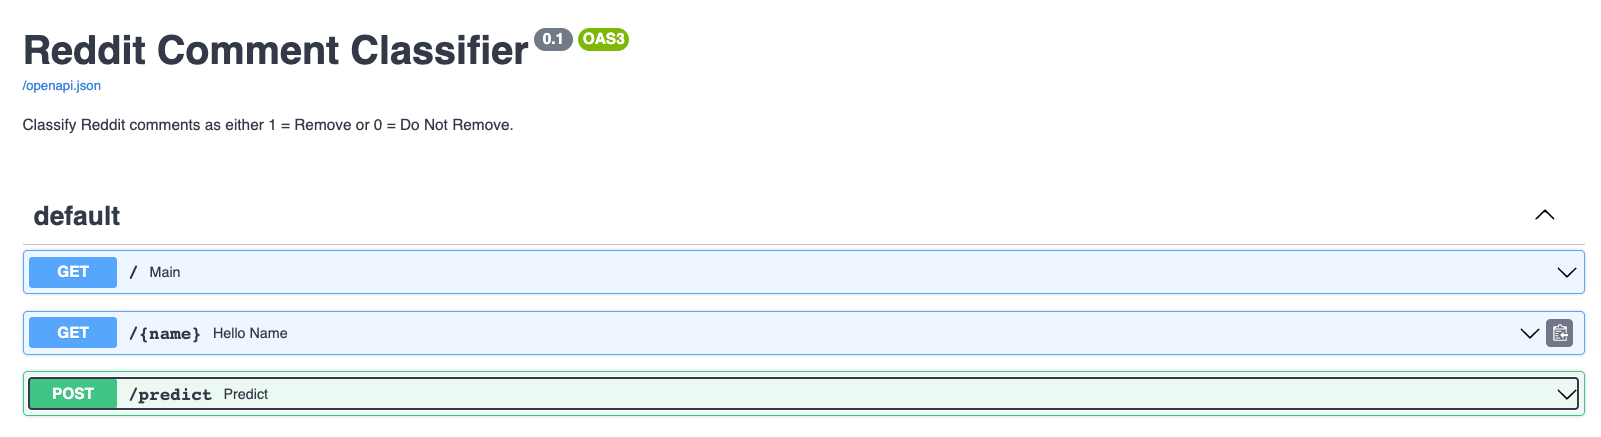

If we go to the POST section and click the down arrow we'll be able to try out an API request by hitting the `Try it out` button:

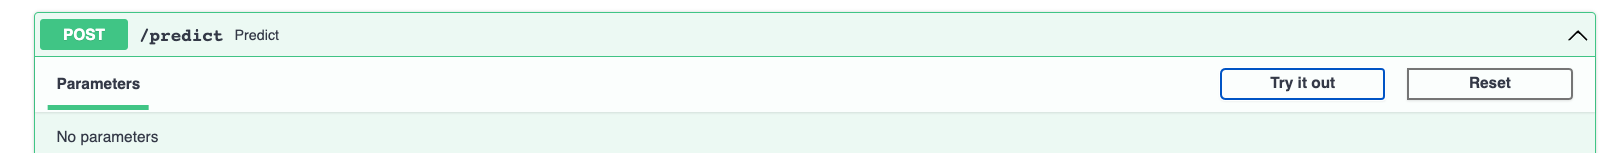

Then we can input our own comment and hit execute:

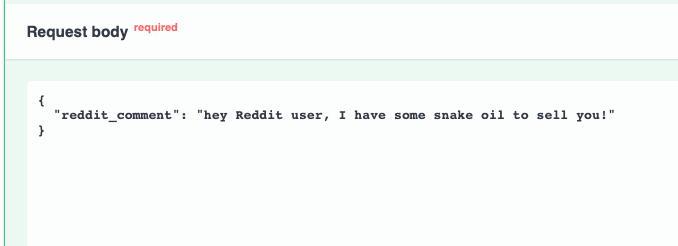

And then we can scroll down to see the predictions made for our comment:

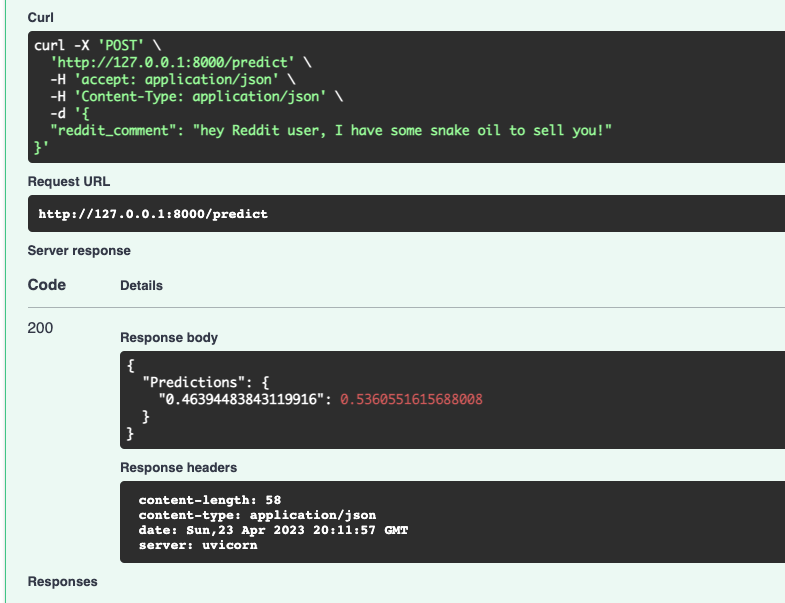

Notice the `curl` command that was created when we hit execute which shows the method **POST**, the endpoint and resource `http://127.0.0.1:8000/predict`, the headers (`-H`, which basically say we are sending and receiving JSON), and then the body (`-d`, JSON object which has our comment that we want to get predictions on). 

### Test App with Python

Instead of using `curl` we can also test the app using a simple python script and the `requests` library. Let's create a script that can test the app for us. Copy the code below and save it as `test_app.py` and then we can run it in the terminal using `python test_app.py`, as long as our app is actually running, to see if it works. Or you can simply run the code block below in this notebook and see if you get a set of predictions back.

In [6]:
import requests

comment = {'reddit_comment':'Testing a comment.'}

url = 'http://127.0.0.1:8000/predict'
response = requests.post(url, json=comment)
print(response.json())

{'Predictions': {'0.3524878769638867': 0.6475121230361133}}


### Containerize

At this point we should consider putting our app into a container. This way we can share it, and truly think about scaling it out. We can do this part ourselves by writing a Dockerfile and then building and running the container locally. Recall that in order to create a Dockerfile, we just need to go step-by-step and figure out what it is that we need in our container so that the app will run.

First, we need a python base image. I will use my version of python that I've been using, which is 3.13.3.  
Then, we need our list of requirements so that we can install them. For the app we used:

```
scikit-learn==1.6.1
numpy==2.2.5
uvicorn==0.34.2
fastapi==0.115.12
joblib==1.4.2
pydantic==2.11.3
```

Then, we should change the working directory and copy over the files that we need for our app to run.    

Then, we need to expose the port.  

And lastly we tell Docker what to actually **run** when we run the container.  

Let's build out the dockerfile and see how it goes.

`touch Dockerfile`

And now add the following to the Dockerfile.

```
FROM python:3.13-slim

RUN pip install -U pip 

WORKDIR /app

COPY [ "requirements.txt", "./" ]

RUN pip install -r requirements.txt

COPY [ "reddit_model_pipeline.joblib", "redditApp.py", "./"]

EXPOSE 8000

# --host=0.0.0.0 is necessary when using uvicorn inside a docker container so that you can connect to localhost or 127.0.0.1 from outside of container
ENTRYPOINT [ "uvicorn", "redditApp:app", "--host", "0.0.0.0"]
```

Once the Dockerfile and the requirements.txt file is written, we can build and run the app:

`docker build -t redditapp:v1 .`  
`docker run -it -p 8000:8000 redditapp:v1`

And then we can run the `test_app.py` file to test if our app is actually running. Ok, so our app is running in a container, which is cool. We can use curl commands, like below, and get predictions back. But, it was a little bit of work getting our Dockerfile to work correctly, and it's still not an ideal way to share with others that might need to test out the application. Having a simple UI, where we can get others to quickly go and test out the app, and provide feedback, might be very useful.

```
curl -X 'POST' \
'http://127.0.0.1:8000/predict' \
-H 'accept: application/json' \
-H 'Content-Type: application/json' \
-d '{"reddit_comment": "Useless comment, you should flag it for removal"}'
```

### Create a UI Using Streamlit

Another option we have for creating a very quick prototype of an application that we can interact with in order to test out our model, or to share with others on our team so that they can test it out, is to build a *data app*, or a dashboard, and expose the model that way with a simple UI. This is fairly easy to do, and there are several tools available that we can use, such as Dash and Streamlit. For those of us who like to work on the frontend, we could also just create a UI and keep our app in FastAPI or use Flask instead. For this demo, let's use Streamlit. Before we start, we should check out the docs [here](https://docs.streamlit.io/library/get-started), and take a look at the API reference. We'll quickly see how simple Streamlit is to use.

First, let's install Streamlit, and make a new `streamlit/` folder in our project root folder.

In [ ]:
!pip install streamlit

In our `streamlit/` folder, let's create a new file called `app.py`.

`touch app.py`  
`streamlit run app.py`

You won't see much yet, we'll build it out in due time. 

The first step when building out the UI for our app is to think about the design. We should not just jump into writing the code. We should take a step back, and think about what it should look like. We should draw some diagrams and think about the different personas that will be using the app. But, we should also remember that this is a prototype, so we shouldn't go overboard designing an amazingly slick app. I like to think about the app as two steps: the UI and the Server. This comes from my days of using [Shiny in R](https://shiny.rstudio.com/) which has been around for more than a decade. Thinking about the UI first will help us get something on the screen quickly, and help us figure out how to write the code to actually produce the outputs to the screen that we want to see.

For the UI, for this particular app, all we really have is a simple text input and then the predictions as output. It's not terribly complicated, but we can make it more fancy. What if we want to upload a csv file that has a batch of comments in it and generate a prediction for each comment in the file? What if we want to download a csv file that has the comments with the predictions appended? What if we want to see other details of the model within the app, such as performance metrics, or some chart that tells us about the performance of the model on a testing set of data? We could add all of these things in pieces and see how it goes. First, we'll need the input text field, and an output that displays the predictions to us. 

We should start with copying over pipeline file that we need for the app to run to our new `streamlit/` folder. Then, in our `app.py` we can add the following code below. This is the bare minimum that is needed. We have a title using `st.title()`. We have some simple description using `st.markdown()`. We create an area for inputting our text using `st.text_area()`. Then we have the code we need to actually take that text and generate a prediction, and we output the prediction to the screen using `st.write()`. That's all there is to it to make the most basic of apps. 

In [ ]:
import streamlit as st
import joblib

st.title("Reddit Comment Classification")
st.markdown("### All you have to do to use this app is enter a comment and hit the Predict button.")

reddit_comment = [st.text_area("Input your comment here:")]

def load_artifacts():
    model_pipeline = joblib.load("reddit_model_pipeline.joblib")
    return model_pipeline

model_pipeline = load_artifacts()

def predict(reddit_comment):
    X = reddit_comment
    predictions = model_pipeline.predict_proba(X)
    return {'Predictions': predictions}

preds = predict(reddit_comment)
st.write(preds)

Save the above in `app.py` and run it using `streamlit run app.py`. The app will open in a browser and you can go in and enter a comment and see the prediction, and it will look like something like this: 

![](images/streamlit1.png)

We can continue to build off of this by changing the way we write the results out to the screen. Rather than output a JSON object, let's actually output the prediction with a description using `st.metric()`. Then, let's add a file upload button using `st.file_uploader()` so that we can get predictions for a batch of comments. We'll also add a download button using `st.download_button()` so that we can download the results of our batch predictions.

In [ ]:
import streamlit as st
import joblib

st.title("Reddit Comment Classification")
st.markdown("### All you have to do to use this app is enter a comment and hit the Predict button.")

reddit_comment = [st.text_area("Input your comment here:")]

def load_artifacts():
    model_pipeline = joblib.load("reddit_model_pipeline.joblib")
    return model_pipeline

model_pipeline = load_artifacts()

def predict(reddit_comment):
    X = reddit_comment
    predictions = model_pipeline.predict(X)
    return predictions 

preds = predict(reddit_comment)
st.metric("Should this comment be removed (0: No; 1: Yes)", preds.round(2))

st.header("Get a Batch of Predictions")

batches = st.file_uploader("Upload File", type='csv')

if batches is not None:
    dataframe = pd.read_csv(batches, header=None).to_numpy().reshape((-1,))
    batch_predictions = pd.DataFrame(predict(dataframe))
    batch_predictions["Comment"] = dataframe
    batch_predictions.rename(columns={0:"Keep", 1:"Remove"}, inplace=True)
    st.write(batch_predictions)
    st.download_button('Download Predictions', data=batch_predictions.to_csv().encode('utf-8'), file_name='predictions.csv', mime='text/csv',)

Ok, that is looking a lot better, and is simple enough to work. We don't need to clutter it up with anything. We can share the app and get feedback and add to the app, or change it, based on the feedback we get, until we get to a final version that we can either try to deploy, or to develop into a more *production-worthy* application.

There are multiple ways to deploy the app, which we can read about [here](https://docs.streamlit.io/knowledge-base/tutorials/deploy). There is a Streamlit Community Cloud that will host the apps for you for free. We can also deploy in the cloud, for example with Google App Engine. Regardless of how we deploy it, we should containerize our app using Docker. 

Let's create the Dockerfile similar to what we did when we used FastAPI. We can use a lot of the same lines from the Dockerfile and change the last entry for `ENTRYPOINT`.

```
FROM python:3.13-slim

RUN pip install -U pip 

WORKDIR /app

COPY [ "requirements.txt", "./" ]

RUN pip install -r requirements.txt

COPY [ "reddit_model_pipeline.joblib", "app.py", "./"]

EXPOSE 8000

ENTRYPOINT ["streamlit", "run", "app.py", "--server.port=8501", "--server.address=0.0.0.0"]
```

And we also need to change the entries of our `requirements.txt` file, and save this one in the `streamlit/` folder. 

And then we can build the image and run our app using:

`docker build -t streamlitapp .`  
`docker run -it -p 8501:8501 streamlitapp`

To be fair, Streamlit apps are really not meant for being put in production. Streamlit is great for prototyping, but when it comes time to productionize any app that might get significant traffic, it's best to build that out separately. In the next section we'll abandon Streamlit and use a tool that was built for creating scalable REST or gRPC APIs for ML models, and try to deploy it on Kubernetes in GCP.

# Model Deployment Lab

## Overview

There are many ways to deploy a model, but they all fall in two categories: offline and online. The difference between the two is that offline models are not running live - they are executed on a schedule or they are triggered by an even. Online models are always running, and waiting/listening for either events to occur or a request. 

Offline model deployments are extremely flexible, and can be accomplished with different combinations of tools for the compute layer and the scheduler. Online deployments can also be somewhat flexible, but the tools used will depend highly on how the predictions will be used. 

## Goal

The goal of this lab is to create a real-time model scoring process for our dataset that we've been using in previous labs. Although an offline deployment might make more sense for your dataset, we will use this lab to test out an online deployment, using FastAPI. Previously, we used Metaflow to create a scoring flow, which could be used in an offline deployment if we wanted to, by triggering it to run using a simple scheduler, or by scaling it out using Argo Workflows.

## Instructions

Create a basic web app for your model using FastAPI. It should:

- take a request   
- load your model from MLFlow, any one that you've built in a previous lab     
- return a prediction   

and it should work locally using a curl command and using a `test_app.py` script which uses the requests library. There is no need to create a streamlit app for this lab.

Create a new `lab8app/` folder, and add your app script and `test_app.py` to it. Use a curl command to get a prediction and **take a screenshot** of the command and the output. Run `test_app.py` and **take a screenshot** of the output. Lastly, push your code to Github.

## Turning It In

In a doc add the Github URL direct to the `lab8app/` folder, add the two screenshots from above, and upload to Canvas as a pdf.